In [2]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Pipeline

In [143]:
def evaluate(lstm_path = 'results/', rnng_path = '../OpenMind/outputs/' , test = 'Classifier' , modifier = 'none',columns=4, plot=True,annotate=True):
    '''Evaluate the surprisal files for both the LSTM model and the RNNG model. Returns a summary table and/or 
        histogram and sentences with annotations.'''
    
    if test == 'Classifier':
        abs_test = 'cls'
    elif test == 'Missing_Object':
        abs_test = 'mobj'
    elif test == 'Verb_Noun':
        abs_test = 'vo'
        
    lstm_path = lstm_path + test + '/'
    surp_lstm = pd.read_csv(lstm_path + 'surprisals_' + abs_test + '_' + modifier + '.tsv', sep='\t', header=0)
    surp_rnng = pd.read_table(rnng_path + 'surprisals_output_' + abs_test + '_' + modifier + '.txt', header=0)
    sent = pd.read_table("test_suites/" + test + "/" + abs_test + "_" + modifier + "_txt.txt",header=None)
    assert len(surp_lstm) == len(surp_rnng)
    
    if columns == 4:
        df_lstm = pd.DataFrame(data=surprisal_by_tests(surp_lstm),columns=['G1','U1','G2','U2'])
        df_rnng = pd.DataFrame(data=surprisal_by_tests(surp_rnng),columns=['G1','U1','G2','U2'])
        
        # calculate difference between ungrammatical and grammatical sentences
        
        first_noun_lstm = df_lstm['U1'] - df_lstm['G1'] 
        second_noun_lstm = df_lstm['U2'] - df_lstm['G2'] 
        first_class_lstm = df_lstm['U2'] - df_lstm['G1'] 
        second_class_lstm = df_lstm['U1'] - df_lstm['G2'] 
        
        first_noun_rnng = df_rnng['U1'] - df_rnng['G1'] 
        second_noun_rnng = df_rnng['U2'] - df_rnng['G2'] 
        first_class_rnng = df_rnng['U2'] - df_rnng['G1'] 
        second_class_rnng = df_rnng['U1'] - df_rnng['G2'] 
        
        lstm_first_noun = calc_accuracy(first_noun_lstm)
        lstm_second_noun = calc_accuracy(second_noun_lstm)
        lstm_first_class = calc_accuracy(first_class_lstm)
        lstm_second_class = calc_accuracy(second_class_lstm)
        lstm_total = np.mean([lstm_first_noun,lstm_second_noun,lstm_first_class,lstm_second_class])

        rnng_first_noun = calc_accuracy(first_noun_rnng)
        rnng_second_noun = calc_accuracy(second_noun_rnng)
        rnng_first_class = calc_accuracy(first_class_rnng)
        rnng_second_class = calc_accuracy(second_class_rnng)
        rnng_total = np.mean([rnng_first_noun,rnng_second_noun,rnng_first_class,rnng_second_class])
        
        
        data = [[np.round(lstm_first_noun,3),np.round(lstm_second_noun,3),np.round(lstm_first_class,3),np.round(lstm_second_class,3),np.round(lstm_total,3)],
               [np.round(rnng_first_noun,3),np.round(rnng_second_noun,3),np.round(rnng_first_class,3),np.round(rnng_second_class,3),np.round(rnng_total,3)]]
        table = pd.DataFrame(data)
        table.index = ['lstm','rnng']
        table.columns = ['First noun', 'Second noun', 'First classifier', 'Second classifier', 'Total']
        print(table)
        
        if plot:
            fig,ax = plt.subplots(2,2,figsize=(10,8))
            ax[0][0].hist(first_noun_lstm,alpha= 0.8,bins=30,edgecolor='white')
            ax[0][0].set_title('U1 - G1')
            ax[0][1].hist(second_noun_lstm,alpha= 0.8,bins=30,edgecolor='white')
            ax[0][1].set_title('U2 - G2')
            ax[1][0].hist(first_class_lstm,alpha= 0.8,bins=30,edgecolor='white')
            ax[1][0].set_title('U2 - G1')
            ax[1][1].hist(second_class_lstm,alpha= 0.8,bins=30,edgecolor='white')
            ax[1][1].set_title('U1 - G2')
            fig.suptitle('Histogram LSTM ' + test + ' - ' + modifier)
            
            fig,ax = plt.subplots(2,2,figsize=(10,8))
            ax[0][0].hist(first_noun_rnng,alpha= 0.8,bins=30,edgecolor='white')
            ax[0][0].set_title('U1 - G1')
            ax[0][1].hist(second_noun_rnng,alpha= 0.8,bins=30,edgecolor='white')
            ax[0][1].set_title('U2 - G2')
            ax[1][0].hist(first_class_rnng,alpha= 0.8,bins=30,edgecolor='white')
            ax[1][0].set_title('U2 - G1')
            ax[1][1].hist(second_class_rnng,alpha= 0.8,bins=30,edgecolor='white')
            ax[1][1].set_title('U1 - G2')
            fig.suptitle('Histogram RNNG ' + test + ' - ' + modifier)
            
        if annotate:
            if test == 'Classifier':
                for i in range(len(first_noun_lstm)):
                    print(i)
                    print('1: ', sent.loc[i*4].values[0], 'Freq:', dict_freq[sent.loc[i*4].values[0].split(' ')[-2]], '; LSTM: ', round(df_lstm['G1'].loc[i],3), '; RNNG: ',  round(df_rnng['G1'].loc[i],3), 
                          '\n2: ', sent.loc[1+i*4].values[0],'Freq:', dict_freq[sent.loc[1+i*4].values[0].split(' ')[-2]], '; LSTM: ', round(df_lstm['U1'].loc[i],3), '; RNNG: ',  round(df_rnng['U1'].loc[i],3),
                          '\n3: ',sent.loc[2+i*4].values[0], 'Freq:', dict_freq[sent.loc[2+i*4].values[0].split(' ')[-2]],'; LSTM: ', round(df_lstm['G2'].loc[i],3), '; RNNG: ', round(df_rnng['G2'].loc[i],3),
                          '\n4: ',sent.loc[3+i*4].values[0], 'Freq:', dict_freq[sent.loc[3+i*4].values[0].split(' ')[-2]],'; LSTM: ', round(df_lstm['U2'].loc[i],3), '; RNNG: ', round(df_rnng['U2'].loc[i],3))
                    print('2 - 1: ', 'LSTM: ', round(first_noun_lstm[i],3), '; RNNG: ', round(first_noun_rnng[i],3))
                    print('4 - 3: ', 'LSTM: ', round(second_noun_lstm[i],3), '; RNNG: ', round(second_noun_rnng[i],3))
                    print('4 - 1: ', 'LSTM: ', round(first_class_lstm[i],3),'; RNNG: ', round(first_class_rnng[i],3))
                    print('2 - 3: ', 'LSTM: ', round(second_class_lstm[i],3), '; RNNG: ', round(second_class_rnng[i],3))
                    print('\n')
                    
            else:
                for i in range(len(first_noun_lstm)):
                    print(i)
                    print('1: ', sent.loc[i*4].values[0], 'LSTM: ', round(df_lstm['G1'].loc[i],3), '; RNNG: ',  round(df_rnng['G1'].loc[i],3), 
                          '\n2: ', sent.loc[1+i*4].values[0], 'LSTM: ', round(df_lstm['U1'].loc[i],3), '; RNNG: ',  round(df_rnng['U1'].loc[i],3),
                          '\n3: ',sent.loc[2+i*4].values[0], 'LSTM: ', round(df_lstm['G2'].loc[i],3), '; RNNG: ', round(df_rnng['G2'].loc[i],3),
                          '\n4: ',sent.loc[3+i*4].values[0], 'LSTM: ', round(df_lstm['U2'].loc[i],3), '; RNNG: ', round(df_rnng['U2'].loc[i],3))
                    print('2 - 1: ', 'LSTM: ', round(first_noun_lstm[i],3), '; RNNG: ', round(first_noun_rnng[i],3))
                    print('4 - 3: ', 'LSTM: ', round(second_noun_lstm[i],3), '; RNNG: ', round(second_noun_rnng[i],3))
                    print('4 - 1: ', 'LSTM: ', round(first_class_lstm[i],3),'; RNNG: ', round(first_class_rnng[i],3))
                    print('2 - 3: ', 'LSTM: ', round(second_class_lstm[i],3), '; RNNG: ', round(second_class_rnng[i],3))
                    print('\n')
   
    elif columns == 2:
        if test != 'Verb_Noun':
            df_lstm = pd.DataFrame(data=surprisal_by_tests(surp_lstm,columns=2,target=-1),columns=['U','G'])
            df_rnng = pd.DataFrame(data=surprisal_by_tests(surp_rnng,columns=2,target=-1),columns=['U','G'])
        else:
            df_lstm = pd.DataFrame(data=surprisal_by_tests(surp_lstm,columns=2,target=-2),columns=['G','U'])
            df_rnng = pd.DataFrame(data=surprisal_by_tests(surp_rnng,columns=2,target=-2),columns=['G','U'])
        
        diff_lstm = df_lstm['U'] - df_lstm['G'] 
        diff_rnng = df_rnng['U'] - df_rnng['G']
        
        lstm = calc_accuracy(diff_lstm)
        rnng = calc_accuracy(diff_rnng)
        
        data = [[np.round(lstm,3)],
               [np.round(rnng,3)]]
        table = pd.DataFrame(data)
        table.index = ['lstm','rnng']
        table.columns = ['Ratio']
        print(table)
        print('\n')
        
        if plot:
            fig, ax = plt.subplots(2,1,figsize=(10,8))
            ax[0].hist(diff_lstm,alpha= 0.8,bins=30,edgecolor='white')
            ax[0].set_title('LSTM ' + test + ' - ' + modifier + ' U - G')
            ax[1].hist(diff_rnng,alpha= 0.8,bins=30,edgecolor='white')
            ax[1].set_title('RNNG ' + test + ' - ' + modifier + ' U - G')
            fig.suptitle('Histogram Missing Object')
            
        if annotate:
            for i in range(len(diff_lstm)):
                print(i)
                if test != 'Verb_Noun':
                    print('1: ', sent.loc[i*2].values[0], 'LSTM: ',round(df_lstm['U'].loc[i],3),'; RNNG:',round(df_rnng['U'].loc[i],3),
                      '\n2: ', sent.loc[1+i*2].values[0],'LSTM: ', round(df_lstm['G'].loc[i],3),'; RNNG:',round(df_rnng['G'].loc[i],3))
                else:
                    print('1: ', sent.loc[i*2].values[0], 'LSTM: ',round(df_lstm['G'].loc[i],3),'; RNNG:',round(df_rnng['G'].loc[i],3),
                      '\n2: ', sent.loc[1+i*2].values[0],'LSTM: ', round(df_lstm['U'].loc[i],3),'; RNNG:',round(df_rnng['U'].loc[i],3))
                print('U - G: ', 'LSTM: ', round(diff_lstm[i],3),'; RNNG: ', round(diff_rnng[i],3))
                print('\n')
        
    return table
        

In [97]:
df_freq = pd.read_csv('../cls_noun_freq.csv',header=0)

In [117]:
df_freq=df_freq.set_index('noun')
dict_freq = df_freq.to_dict(orient='dict')
dict_freq = dict_freq['freq']

In [125]:
# evaluate(test = 'Classifier' , modifier = 'none',columns=4,annotate=True,plot=False)

      First noun  Second noun  First classifier  Second classifier  Total
lstm       0.800        0.733             0.667              0.567  0.692
rnng       0.733        0.733             0.633              0.400  0.625
0
1:  我 很 喜欢 一 位 明星 。 Freq: 36 ; LSTM:  16.537 ; RNNG:  14.707 
2:  我 很 喜欢 一 首 明星 。 Freq: 36 ; LSTM:  19.467 ; RNNG:  18.446 
3:  我 很 喜欢 一 首 歌曲 。 Freq: 25 ; LSTM:  16.786 ; RNNG:  15.416 
4:  我 很 喜欢 一 位 歌曲 。 Freq: 25 ; LSTM:  22.33 ; RNNG:  17.136
2 - 1:  LSTM:  2.93 ; RNNG:  3.739
4 - 3:  LSTM:  5.544 ; RNNG:  1.72
4 - 1:  LSTM:  5.793 ; RNNG:  2.429
2 - 3:  LSTM:  2.681 ; RNNG:  3.03


1
1:  她 开车 去 了 一 家 店 。 Freq: 102 ; LSTM:  15.091 ; RNNG:  10.552 
2:  她 开车 去 了 一 座 店 。 Freq: 102 ; LSTM:  16.435 ; RNNG:  11.898 
3:  她 开车 去 了 一 座 山 。 Freq: 49 ; LSTM:  16.965 ; RNNG:  12.355 
4:  她 开车 去 了 一 家 山 。 Freq: 49 ; LSTM:  19.771 ; RNNG:  13.037
2 - 1:  LSTM:  1.344 ; RNNG:  1.346
4 - 3:  LSTM:  2.806 ; RNNG:  0.682
4 - 1:  LSTM:  4.68 ; RNNG:  2.485
2 - 3:  LSTM:  -0.53 ; RN

,First noun,Second noun,First classifier,Second classifier,Total
lstm,0.800,0.733,0.667,0.567,0.692
rnng,0.733,0.733,0.633,0.400,0.625


In [134]:
## check term frequency matters or not
total_1_2 = 0
neg_1_2 = 0
total_2_1 = 0
neg_2_1 = 0
for i in range(len(first_noun_lstm)):
    if dict_freq[sent_none.loc[i*4].values[0].split(' ')[-2]] > 4*dict_freq[sent_none.loc[2+i*4].values[0].split(' ')[-2]]:
        total_1_2 += 1
        if second_class_rnng[i] < 0:
            neg_1_2 += 1
            print(sent_none.loc[i*4].values[0].split(' ')[-2])
    if 4*dict_freq[sent_none.loc[i*4].values[0].split(' ')[-2]] < dict_freq[sent_none.loc[2+i*4].values[0].split(' ')[-2]]:
        total_2_1 += 1
        if first_class_rnng[i] < 0:
            neg_2_1 += 1
            print(sent_none.loc[i*4].values[0].split(' ')[-2])
    

电影
表演
菜
学生
房子
玫瑰
评论
老虎
作业
电视
景点


In [130]:
print('First noun more frequent, and 2-3 negative ratio: ', neg_1_2/total_1_2)
print('Second noun more frequent, and 4-1 negative ratio: ', neg_2_1/total_2_1)

First noun more frequent, and 2-3 negative ratio:  0.8
Second noun more frequent, and 4-1 negative ratio:  0.75


In [ ]:
evaluate(test = 'Classifier' , modifier = 'none',columns=4,annotate=True,plot=False)

      Ratio
lstm  0.935
rnng  0.968




,Ratio
lstm,0.935
rnng,0.968


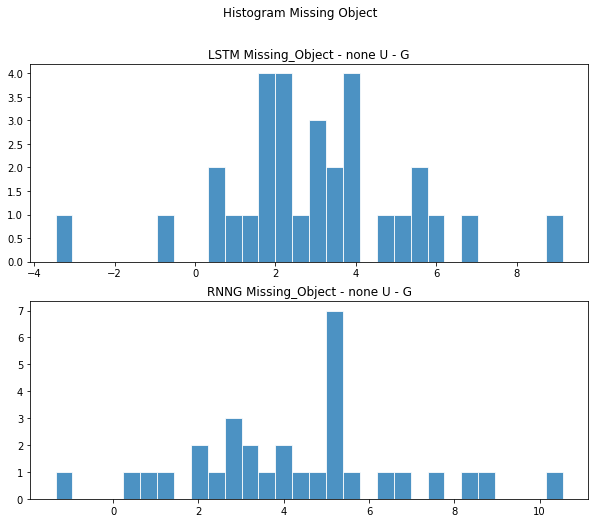

In [91]:
evaluate(test = 'Missing_Object' , modifier = 'none',columns=2,annotate=False)

      Ratio
lstm  0.839
rnng  0.903




,Ratio
lstm,0.839
rnng,0.903


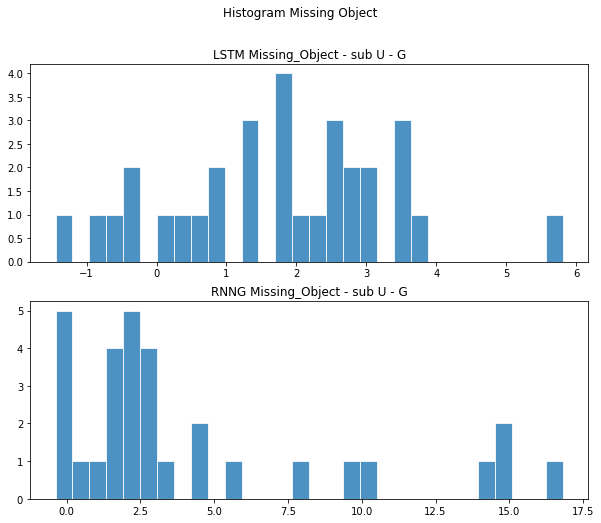

In [90]:
evaluate(test = 'Missing_Object' , modifier = 'sub',columns=2,annotate=False)

      Ratio
lstm  0.839
rnng  0.806




,Ratio
lstm,0.839
rnng,0.806


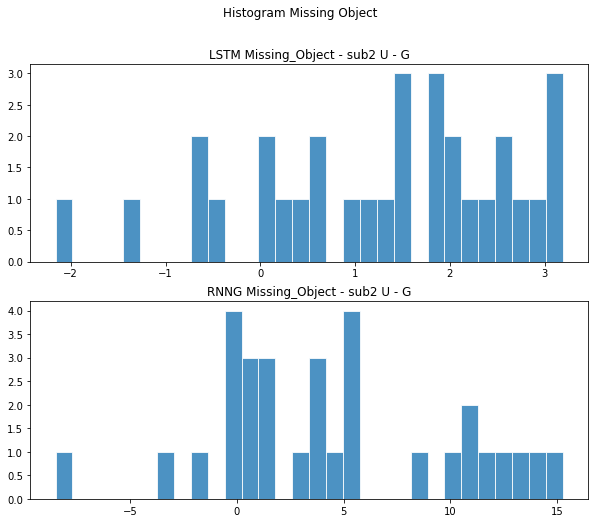

In [88]:
evaluate(test = 'Missing_Object' , modifier = 'sub2',columns=2,annotate=False)

      Ratio
lstm  0.677
rnng  0.645




,Ratio
lstm,0.677
rnng,0.645


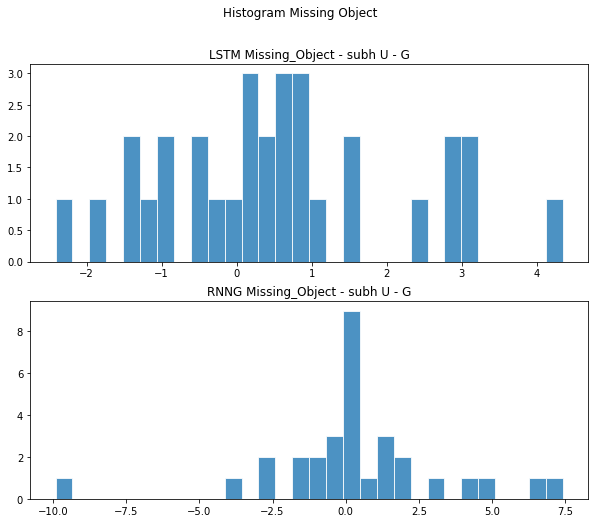

In [89]:
evaluate(test = 'Missing_Object' , modifier = 'subh',columns=2,annotate=False)

      Ratio
lstm  0.576
rnng  0.697


0
1:  那 位 教授 写 了 书 的 内容 。 LSTM:  9.19 ; RNNG: 11.409 
2:  那 位 教授 写 了 书 的 作者 。 LSTM:  13.369 ; RNNG: 18.224
U - G:  LSTM:  4.179 ; RNNG:  6.815


1
1:  弟弟 开 了 父亲 的 车 。 LSTM:  11.227 ; RNNG: 15.363 
2:  弟弟 开 了 父亲 的 诗 。 LSTM:  21.854 ; RNNG: 23.997
U - G:  LSTM:  10.627 ; RNNG:  8.634


2
1:  他 读 了 桌子 上 的 报纸 。 LSTM:  17.69 ; RNNG: 19.682 
2:  他 读 了 桌子 上 的 筷子 。 LSTM:  22.321 ; RNNG: 21.251
U - G:  LSTM:  4.631 ; RNNG:  1.569


3
1:  她 终于 实现 了 她 的 理想 。 LSTM:  15.166 ; RNNG: 15.152 
2:  她 终于 实现 了 她 的 任务 。 LSTM:  13.741 ; RNNG: 13.51
U - G:  LSTM:  -1.425 ; RNNG:  -1.642


4
1:  我 修理 了 这个 电脑 。 LSTM:  15.884 ; RNNG: 13.928 
2:  我 修理 了 这个 故事 。 LSTM:  11.984 ; RNNG: 9.995
U - G:  LSTM:  -3.9 ; RNNG:  -3.933


5
1:  他 承担 了 我 的 责任 。 LSTM:  11.464 ; RNNG: 8.528 
2:  他 承担 了 我 的 爱好 。 LSTM:  15.845 ; RNNG: 14.368
U - G:  LSTM:  4.381 ; RNNG:  5.841


6
1:  我 邀请 过 我 的 朋友 。 LSTM:  9.503 ; RNNG: 9.968 
2:  我 邀请 过 我 的 音响 。 LSTM:  23.18 ; RNNG: 26.911
U - G:  LSTM:  13

,Ratio
lstm,0.576
rnng,0.697


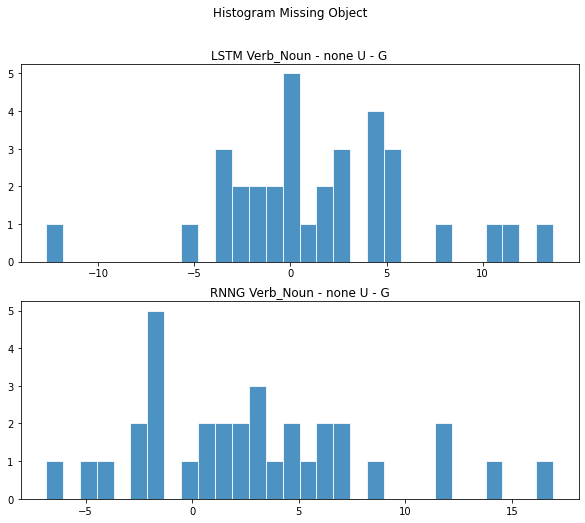

In [144]:
evaluate(test = 'Verb_Noun' , modifier = 'none',columns=2,annotate=True)

      Ratio
lstm  0.576
rnng  0.697


0
1:  那 位 教授 写 了 书 的 序言 和 内容 。 LSTM:  7.306 ; RNNG: 9.738 
2:  那 位 教授 写 了 书 的 序言 和 作者 。 LSTM:  17.089 ; RNNG: 12.778
U - G:  LSTM:  9.783 ; RNNG:  3.04


1
1:  弟弟 开 了 父亲 的 瓶子 和 车 。 LSTM:  15.177 ; RNNG: 19.987 
2:  弟弟 开 了 父亲 的 瓶子 和 诗 。 LSTM:  24.303 ; RNNG: 25.954
U - G:  LSTM:  9.126 ; RNNG:  5.968


2
1:  他 读 了 桌子 上 的 书 和 报纸 。 LSTM:  14.621 ; RNNG: 18.882 
2:  他 读 了 桌子 上 的 书 和 筷子 。 LSTM:  22.016 ; RNNG: 18.982
U - G:  LSTM:  7.395 ; RNNG:  0.1


3
1:  她 终于 实现 了 她 的 目标 和 理想 。 LSTM:  13.075 ; RNNG: 11.552 
2:  她 终于 实现 了 她 的 目标 和 任务 。 LSTM:  10.38 ; RNNG: 9.229
U - G:  LSTM:  -2.695 ; RNNG:  -2.323


4
1:  我 修理 了 这个 电视 和 电脑 。 LSTM:  14.898 ; RNNG: 13.329 
2:  我 修理 了 这个 电视 和 故事 。 LSTM:  16.747 ; RNNG: 14.947
U - G:  LSTM:  1.849 ; RNNG:  1.618


5
1:  他 承担 了 我 的 义务 和 责任 。 LSTM:  9.585 ; RNNG: 8.682 
2:  他 承担 了 我 的 义务 和 爱好 。 LSTM:  16.142 ; RNNG: 16.958
U - G:  LSTM:  6.557 ; RNNG:  8.275


6
1:  我 邀请 过 我 的 老师 和 朋友 。 LSTM:  8.054 ; RNNG: 7.522 
2:  我 

,Ratio
lstm,0.576
rnng,0.697


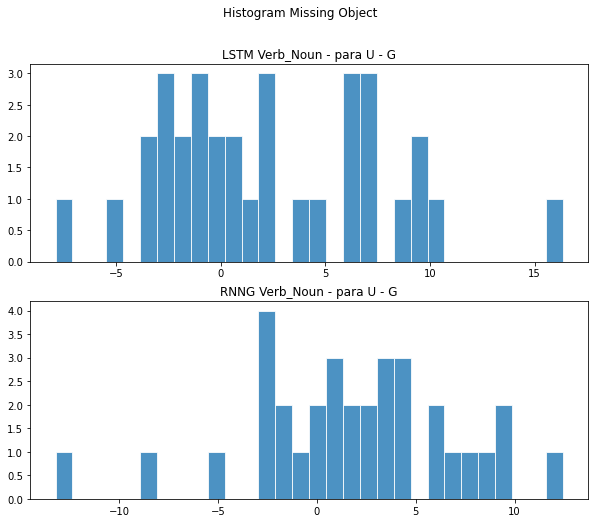

In [145]:
evaluate(test = 'Verb_Noun' , modifier = 'para',columns=2,annotate=True)

## Classifier

In [3]:
path = "results/Classifier/"
rnng_path = "../OpenMind/outputs/"

In [4]:
surp_none_lstm = pd.read_csv(path + 'surprisals_none.tsv', sep='\t', header=0)
surp_none_rnng = pd.read_table(rnng_path + 'surprisals_output_none.txt', header=0)
sent_none = pd.read_table("test_suites/Classifier/cls_none_txt.txt",header=None)
surp_adj_lstm = pd.read_csv(path + 'surprisals_adj.tsv', sep='\t', header=0)
sent_adj = pd.read_table("test_suites/Classifier/cls_adj_txt.txt",header=None)
assert len(surp_none_lstm) == len(surp_none_rnng)

In [5]:
max(surp_none_lstm['sentence_id'])/4

30.0

In [6]:
surp_none_lstm

,sentence_id,token_id,token,surprisal
0,1,1,我,6.978171
1,1,2,很,6.768952
2,1,3,喜欢,4.918214
3,1,4,一,5.979936
4,1,5,位,4.502104
...,...,...,...,...
847,120,2,有,5.617175
848,120,3,一,2.186593
849,120,4,支,5.463740
850,120,5,渔船,12.524443


In [7]:
def surprisal_by_tests(df,columns=4,target=-2):
    total = []
    for suites in range(int(max(df['sentence_id'])/columns)):
        surprisal = []
        for sent in range(1+suites*columns,1+(1+suites)*columns):
            temp = df.loc[df['sentence_id']==sent]
            max_token = temp.token_id.values[-1]
            if target == -2:
                surp_noun = temp.loc[temp['token_id']==max_token].surprisal.values + temp.loc[temp['token_id']==(max_token-1)].surprisal.values
            elif target == -1:
                surp_noun = temp.loc[temp['token_id']==max_token].surprisal.values
            surprisal.append(surp_noun[0])
        total.append(surprisal)
    return total


In [38]:
none_df_lstm = pd.DataFrame(data=surprisal_by_tests(surp_none_lstm),columns=['G1','U1','G2','U2'])
none_df_rnng = pd.DataFrame(data=surprisal_by_tests(surp_none_rnng),columns=['G1','U1','G2','U2'])
adj_df_lstm = pd.DataFrame(data=surprisal_by_tests(surp_adj_lstm),columns=['G1','U1','G2','U2'])

In [39]:
# none
first_noun_lstm = none_df_lstm['U1'] - none_df_lstm['G1'] 
second_noun_lstm = none_df_lstm['U2'] - none_df_lstm['G2'] 
first_class_lstm = none_df_lstm['U2'] - none_df_lstm['G1'] 
second_class_lstm = none_df_lstm['U1'] - none_df_lstm['G2'] 

first_noun_rnng = none_df_rnng['U1'] - none_df_rnng['G1'] 
second_noun_rnng = none_df_rnng['U2'] - none_df_rnng['G2'] 
first_class_rnng = none_df_rnng['U2'] - none_df_rnng['G1'] 
second_class_rnng = none_df_rnng['U1'] - none_df_rnng['G2'] 

# adj
# first_adj_lstm = adj_df_lstm['U1'] - adj_df_lstm['G1'] 
# second_adj_lstm = adj_df_lstm['U2'] - adj_df_lstm['G2'] 
# first_class_lstm = adj_df_lstm['U2'] - adj_df_lstm['G1'] 
# second_class_lstm = adj_df_lstm['U1'] - adj_df_lstm['G2'] 

In [14]:
# assert first_adj_lstm.mean() > 0 , "First Noun - Classifier Pair fails a lot"
# assert second_adj_lstm.mean() > 0 , "Second Noun - Classifier Pair fails a lot"
# assert first_class_lstm.mean() > 0 , "First Classifier - Noun Pair fails a lot"
# assert second_class_lstm.mean() > 0 , "Second Classifier - Noun Pair fails a lot"

Text(0.5, 0.98, 'LSTM Classifier - None')

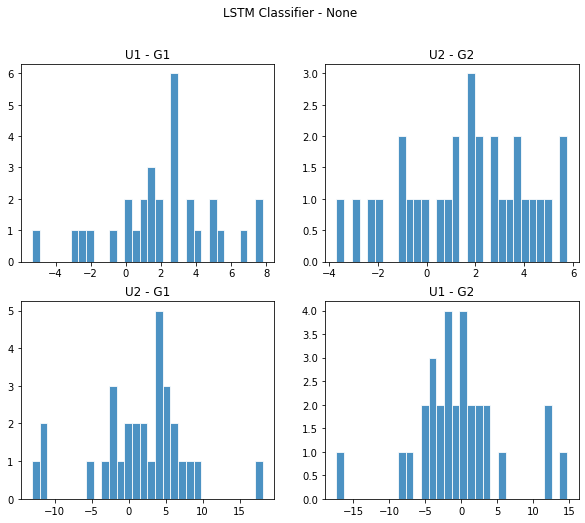

In [15]:
fig,ax = plt.subplots(2,2,figsize=(10,8))
ax[0][0].hist(first_noun_lstm,alpha= 0.8,bins=30,edgecolor='white')
ax[0][0].set_title('U1 - G1')
ax[0][1].hist(second_noun_lstm,alpha= 0.8,bins=30,edgecolor='white')
ax[0][1].set_title('U2 - G2')
ax[1][0].hist(first_class_lstm,alpha= 0.8,bins=30,edgecolor='white')
ax[1][0].set_title('U2 - G1')
ax[1][1].hist(second_class_lstm,alpha= 0.8,bins=30,edgecolor='white')
ax[1][1].set_title('U1 - G2')
fig.suptitle('LSTM Classifier - None')

Text(0.5, 0.98, 'RNNG Classifier - None')

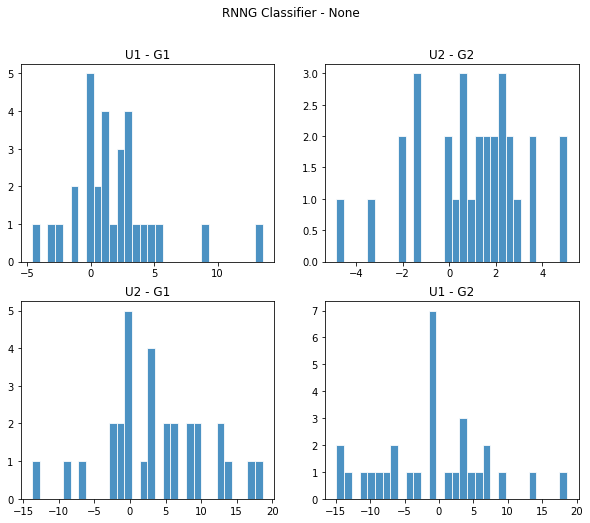

In [16]:
fig,ax = plt.subplots(2,2,figsize=(10,8))
ax[0][0].hist(first_noun_rnng,alpha= 0.8,bins=30,edgecolor='white')
ax[0][0].set_title('U1 - G1')
ax[0][1].hist(second_noun_rnng,alpha= 0.8,bins=30,edgecolor='white')
ax[0][1].set_title('U2 - G2')
ax[1][0].hist(first_class_rnng,alpha= 0.8,bins=30,edgecolor='white')
ax[1][0].set_title('U2 - G1')
ax[1][1].hist(second_class_rnng,alpha= 0.8,bins=30,edgecolor='white')
ax[1][1].set_title('U1 - G2')
fig.suptitle('RNNG Classifier - None')

In [20]:
sum(first_noun_rnng>0)/len(first_noun_rnng)

0.7333333333333333

In [40]:
def calc_accuracy(data):
    '''Calculate the proportion of the test suites that the model predicts as expected'''
    return sum(data>0)/len(data)

In [41]:
lstm_cls_first_noun = calc_accuracy(first_noun_lstm)
lstm_cls_second_noun = calc_accuracy(second_noun_lstm)
lstm_cls_first_class = calc_accuracy(first_class_lstm)
lstm_cls_second_class = calc_accuracy(second_class_lstm)
lstm_total = np.mean([lstm_cls_first_noun,lstm_cls_second_noun,lstm_cls_first_class,lstm_cls_second_class])

rnng_cls_first_noun = calc_accuracy(first_noun_rnng)
rnng_cls_second_noun = calc_accuracy(second_noun_rnng)
rnng_cls_first_class = calc_accuracy(first_class_rnng)
rnng_cls_second_class = calc_accuracy(second_class_rnng)
rnng_total = np.mean([rnng_cls_first_noun,rnng_cls_second_noun,rnng_cls_first_class,rnng_cls_second_class])


In [42]:
data = [[np.round(lstm_cls_first_noun,3),np.round(lstm_cls_second_noun,3),np.round(lstm_cls_first_class,3),np.round(lstm_cls_second_class,3),np.round(lstm_total,3)],
       [np.round(rnng_cls_first_noun,3),np.round(rnng_cls_second_noun,3),np.round(rnng_cls_first_class,3),np.round(rnng_cls_second_class,3),np.round(rnng_total,3)]]
table = pd.DataFrame(data)
table.index = ['lstm','rnng']
table.columns = ['First noun', 'Second noun', 'First classifier', 'Second classifier', 'Total']
table

,First noun,Second noun,First classifier,Second classifier,Total
lstm,0.800,0.733,0.667,0.567,0.692
rnng,0.733,0.733,0.633,0.400,0.625


In [44]:
for i in range(len(first_noun_lstm)):
    print(i)
    print('1: ', sent_none.loc[i*4].values[0], 'LSTM: ', round(none_df_lstm['G1'].loc[i],3), '; RNNG: ',  round(none_df_rnng['G1'].loc[i],3), 
          '\n2: ', sent_none.loc[1+i*4].values[0], 'LSTM: ', round(none_df_lstm['U1'].loc[i],3), '; RNNG: ',  round(none_df_rnng['U1'].loc[i],3),
          '\n3: ',sent_none.loc[2+i*4].values[0], 'LSTM: ', round(none_df_lstm['G2'].loc[i],3), '; RNNG: ', round(none_df_rnng['G2'].loc[i],3),
          '\n4: ',sent_none.loc[3+i*4].values[0], 'LSTM: ', round(none_df_lstm['U2'].loc[i],3), '; RNNG: ', round(none_df_rnng['U2'].loc[i],3))
    print('2 - 1: ', 'LSTM: ', round(first_noun_lstm[i],3), '; RNNG: ', round(first_noun_rnng[i],3))
    print('4 - 3: ', 'LSTM: ', round(second_noun_lstm[i],3), '; RNNG: ', round(second_noun_rnng[i],3))
    print('4 - 1: ', 'LSTM: ', round(first_class_lstm[i],3),'; RNNG: ', round(first_class_rnng[i],3))
    print('2 - 3: ', 'LSTM: ', round(second_class_lstm[i],3), '; RNNG: ', round(second_class_rnng[i],3))
    print('\n')
    

0
1:  我 很 喜欢 一 位 明星 。 LSTM:  16.537 ; RNNG:  14.707 
2:  我 很 喜欢 一 首 明星 。 LSTM:  19.467 ; RNNG:  18.446 
3:  我 很 喜欢 一 首 歌曲 。 LSTM:  16.786 ; RNNG:  15.416 
4:  我 很 喜欢 一 位 歌曲 。 LSTM:  22.33 ; RNNG:  17.136
2 - 1:  LSTM:  2.93 ; RNNG:  3.739
4 - 3:  LSTM:  5.544 ; RNNG:  1.72
4 - 1:  LSTM:  5.793 ; RNNG:  2.429
2 - 3:  LSTM:  2.681 ; RNNG:  3.03


1
1:  她 开车 去 了 一 家 店 。 LSTM:  15.091 ; RNNG:  10.552 
2:  她 开车 去 了 一 座 店 。 LSTM:  16.435 ; RNNG:  11.898 
3:  她 开车 去 了 一 座 山 。 LSTM:  16.965 ; RNNG:  12.355 
4:  她 开车 去 了 一 家 山 。 LSTM:  19.771 ; RNNG:  13.037
2 - 1:  LSTM:  1.344 ; RNNG:  1.346
4 - 3:  LSTM:  2.806 ; RNNG:  0.682
4 - 1:  LSTM:  4.68 ; RNNG:  2.485
2 - 3:  LSTM:  -0.53 ; RNNG:  -0.458


2
1:  他 有 一 双 手套 。 LSTM:  23.613 ; RNNG:  17.532 
2:  他 有 一 枚 手套 。 LSTM:  21.409 ; RNNG:  17.599 
3:  他 有 一 枚 纽扣 。 LSTM:  20.831 ; RNNG:  22.19 
4:  他 有 一 双 纽扣 。 LSTM:  22.745 ; RNNG:  24.291
2 - 1:  LSTM:  -2.204 ; RNNG:  0.067
4 - 3:  LSTM:  1.914 ; RNNG:  2.1
4 - 1:  LSTM:  -0.868 ; RNNG:  6.75

RNNG seems to perform a bit better than the LSTM when looking at the same noun different classifier comparisons. However, it performs even worse than the LSTM in cross-noun comparisons.

## Missing Object

In [44]:
surp_none_rnng_mo

,sentence_id,token_id,token,surprisal
0,1,1,记者,10.20740
1,1,2,采访,8.35926
2,1,3,了,4.34739
3,1,4,。,11.92810
4,2,1,记者,10.20740
...,...,...,...,...
301,68,1,我,6.05420
302,68,2,经常,9.21412
303,68,3,去,6.33960
304,68,4,医院,8.84087


In [45]:
path = "results/Missing_Object/"
rnng_path = "../OpenMind/outputs/"
surp_none_lstm_mo = pd.read_csv(path + 'surprisals_mobj_none.tsv', sep='\t', header=0)
surp_none_rnng_mo = pd.read_table(rnng_path + 'surprisals_output_mobj_none.txt', header=0)
sent_none_mo = pd.read_table("test_suites/Missing_Object/mobj_none_txt.txt",header=None)
surp_sub_lstm_mo = pd.read_csv(path + 'surprisals_mobj_sub.tsv', sep='\t', header=0)
surp_sub_rnng_mo = pd.read_table(rnng_path + 'surprisals_output_mobj_sub.txt',header=0)
sent_sub_mo = pd.read_table("test_suites/Missing_Object/mobj_sub_txt.txt",header=None)

In [46]:
none_df_lstm_mo = pd.DataFrame(data=surprisal_by_tests(surp_none_lstm_mo,columns=2,target=-1),columns=['U','G'])
none_df_rnng_mo = pd.DataFrame(data=surprisal_by_tests(surp_none_rnng_mo,columns=2,target=-1),columns=['U','G'])
sub_df_lstm_mo = pd.DataFrame(data=surprisal_by_tests(surp_sub_lstm_mo,columns=2,target=-1),columns=['U','G'])
sub_df_rnng_mo = pd.DataFrame(data=surprisal_by_tests(surp_sub_rnng_mo,columns=2,target=-1),columns=['U','G'])

In [47]:
diff_mobj_none = none_df_lstm_mo['U'] - none_df_lstm_mo['G'] 
diff_mobj_sub = sub_df_lstm_mo['U'] - sub_df_lstm_mo['G'] 
print('LSTM None: ', np.mean(diff_mobj_none),'; Sub: ',np.mean(diff_mobj_sub))

LSTM None:  2.9777296281629995 ; Sub:  1.7310549751404793


In [48]:
diff_mobj_none_rnng = none_df_rnng_mo['U'] - none_df_rnng_mo['G'] 
diff_mobj_sub_rnng = sub_df_rnng_mo['U'] - sub_df_rnng_mo['G'] 
print('RNNG None: ', np.mean(diff_mobj_none_rnng),'; Sub: ',np.mean(diff_mobj_sub_rnng))

RNNG None:  4.664995294117648 ; Sub:  4.726602882352942


Text(0.5, 0.98, 'Missing Object')

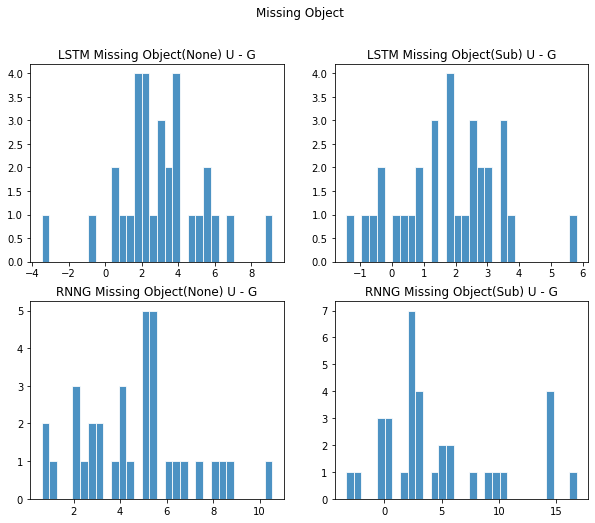

In [49]:
fig, ax = plt.subplots(2,2,figsize=(10,8))
ax[0][0].hist(diff_mobj_none,alpha= 0.8,bins=30,edgecolor='white')
ax[0][0].set_title('LSTM Missing Object(None) U - G')
ax[0][1].hist(diff_mobj_sub,alpha= 0.8,bins=30,edgecolor='white')
ax[0][1].set_title('LSTM Missing Object(Sub) U - G')
ax[1][0].hist(diff_mobj_none_rnng,alpha= 0.8,bins=30,edgecolor='white')
ax[1][0].set_title('RNNG Missing Object(None) U - G')
ax[1][1].hist(diff_mobj_sub_rnng,alpha= 0.8,bins=30,edgecolor='white')
ax[1][1].set_title('RNNG Missing Object(Sub) U - G')
fig.suptitle('Missing Object')

In [51]:
for i in range(len(diff_mobj_none)):
    print(i)
    print('1: ', sent_none_mo.loc[i*2].values[0], 'LSTM: ',round(none_df_lstm_mo['U'].loc[i],3),'; RNNG:',round(none_df_rnng_mo['U'].loc[i],3),
          '\n2: ', sent_none_mo.loc[1+i*2].values[0],'LSTM: ', round(none_df_lstm_mo['G'].loc[i],3),'; RNNG:',round(none_df_rnng_mo['G'].loc[i],3))
    print('U - G: ', 'LSTM: ', round(diff_mobj_none[i],3),'; RNNG: ', round(diff_mobj_none_rnng[i],3))
    print('\n')

0
1:  记者 采访 了 。 LSTM:  3.444 ; RNNG: 11.928 
2:  记者 采访 了 科学家 。 LSTM:  6.915 ; RNNG: 1.382
U - G:  LSTM:  -3.471 ; RNNG:  10.546


1
1:  他 拿出 了 。 LSTM:  8.821 ; RNNG: 15.773 
2:  他 拿出 了 篮子 。 LSTM:  8.18 ; RNNG: 7.306
U - G:  LSTM:  0.641 ; RNNG:  8.467


2
1:  他 认识 了 。 LSTM:  7.358 ; RNNG: 10.378 
2:  他 认识 了 老师 。 LSTM:  4.284 ; RNNG: 3.775
U - G:  LSTM:  3.074 ; RNNG:  6.603


3
1:  他 拍 下 了 。 LSTM:  7.493 ; RNNG: 4.844 
2:  他 拍 下 了 艺术品 。 LSTM:  4.979 ; RNNG: 3.552
U - G:  LSTM:  2.514 ; RNNG:  1.292


4
1:  我们 参加 了 。 LSTM:  8.314 ; RNNG: 9.818 
2:  我们 参加 了 活动 。 LSTM:  2.221 ; RNNG: 1.026
U - G:  LSTM:  6.094 ; RNNG:  8.792


5
1:  他 想起 了 。 LSTM:  10.207 ; RNNG: 10.812 
2:  他 想起 了 同学 。 LSTM:  5.259 ; RNNG: 5.726
U - G:  LSTM:  4.949 ; RNNG:  5.087


6
1:  司机 启动 了 。 LSTM:  3.668 ; RNNG: 6.981 
2:  司机 启动 了 车 。 LSTM:  4.291 ; RNNG: 3.228
U - G:  LSTM:  -0.623 ; RNNG:  3.752


7
1:  爸爸 买 了 。 LSTM:  6.997 ; RNNG: 4.883 
2:  爸爸 买 了 房子 。 LSTM:  4.794 ; RNNG: 2.356
U - G:  LSTM:  2.203 ; RNNG:  

Both LSTM and RNNG work better than in the Classifier case. On top of that, RNNG works extremely better with all positive results as expected.

In [53]:
for i in range(len(diff_mobj_none)):
    print(i)
    print('1: ', sent_sub_mo.loc[i*2].values[0], 'LSTM: ',round(sub_df_lstm_mo['U'].loc[i],3),'; RNNG:',round(sub_df_rnng_mo['U'].loc[i],3),
          '\n2: ', sent_sub_mo.loc[1+i*2].values[0],'LSTM: ', round(sub_df_lstm_mo['G'].loc[i],3),'; RNNG:',round(sub_df_rnng_mo['G'].loc[i],3))
    print('U - G: ', 'LSTM: ', round(diff_mobj_sub[i],3),'; RNNG: ', round(diff_mobj_sub_rnng[i],3))
    print('\n')

0
1:  记者 采访 了 研发 产品 。 LSTM:  4.952 ; RNNG: 3.258 
2:  记者 采访 了 研发 产品 的 科学家 。 LSTM:  4.069 ; RNNG: 0.644
U - G:  LSTM:  0.883 ; RNNG:  2.613


1
1:  他 拿出 了 有 苹果 。 LSTM:  9.398 ; RNNG: 15.068 
2:  他 拿出 了 有 苹果 的 篮子 。 LSTM:  6.525 ; RNNG: 11.77
U - G:  LSTM:  2.873 ; RNNG:  3.298


2
1:  他 认识 了 写 书 。 LSTM:  5.857 ; RNNG: 9.67 
2:  他 认识 了 写 书 的 老师 。 LSTM:  4.146 ; RNNG: 1.995
U - G:  LSTM:  1.711 ; RNNG:  7.675


3
1:  他 拍 下 了 获得 大奖 。 LSTM:  3.444 ; RNNG: 0.313 
2:  他 拍 下 了 获得 大奖 的 艺术品 。 LSTM:  3.861 ; RNNG: 0.236
U - G:  LSTM:  -0.417 ; RNNG:  0.077


4
1:  我们 参加 了 吸引 学生 。 LSTM:  5.49 ; RNNG: 15.464 
2:  我们 参加 了 吸引 学生 的 活动 。 LSTM:  2.532 ; RNNG: 0.899
U - G:  LSTM:  2.958 ; RNNG:  14.565


5
1:  他 想起 了 写 过 歌 。 LSTM:  6.072 ; RNNG: 4.228 
2:  他 想起 了 写 过 歌 的 同学 。 LSTM:  2.585 ; RNNG: 2.002
U - G:  LSTM:  3.487 ; RNNG:  2.225


6
1:  司机 启动 了 装有 音响 。 LSTM:  8.866 ; RNNG: 20.093 
2:  司机 启动 了 装有 音响 的 车 。 LSTM:  3.057 ; RNNG: 3.281
U - G:  LSTM:  5.809 ; RNNG:  16.812


7
1:  爸爸 买 了 带 家具 。 LSTM:  

Both the RNNG and LSTM model's performances suffer a bit when a subject extracted clause is embedded after the main verb. For test suites that RNNG produces negative diff, maybe double-check if the sub-clause makes sense with the selected noun?

In [55]:
for i in range(len(first_adj_lstm)):
    print(i)
    print('1: ', sent_adj.loc[i*4].values[0], round(adj_df_lstm['G1'].loc[i],3),  '\n2: ', sent_adj.loc[1+i*4].values[0], round(adj_df_lstm['U1'].loc[i],3), '\n3: ',sent_adj.loc[2+i*4].values[0], 
          round(adj_df_lstm['G2'].loc[i],3), '\n4: ',sent_adj.loc[3+i*4].values[0], round(adj_df_lstm['U2'].loc[i],3))
    print('2 - 1: ', round(first_adj_lstm[i],3))
    print('4 - 3: ', round(second_adj_lstm[i],3))
    print('4 - 1: ', round(first_class_lstm[i],3))
    print('2 - 3: ', round(second_class_lstm[i],3))
    print('\n')

0
1:  我 很 喜欢 一 位 国内 的 明星 。 14.229 
2:  我 很 喜欢 一 首 国内 的 明星 。 14.754 
3:  我 很 喜欢 一 首 国内 的 歌曲 。 20.052 
4:  我 很 喜欢 一 位 国内 的 歌曲 。 21.548
2 - 1:  0.525
4 - 3:  1.496
4 - 1:  5.793
2 - 3:  2.681


1
1:  她 开车 去 了 一 家 郊外 的 店 。 16.248 
2:  她 开车 去 了 一 座 郊外 的 店 。 16.226 
3:  她 开车 去 了 一 座 郊外 的 山 。 17.669 
4:  她 开车 去 了 一 家 郊外 的 山 。 17.896
2 - 1:  -0.022
4 - 3:  0.227
4 - 1:  4.68
2 - 3:  -0.53


2
1:  他 有 一 双 蓝色 的 手套 。 23.35 
2:  他 有 一 枚 蓝色 的 手套 。 21.792 
3:  他 有 一 枚 蓝色 的 纽扣 。 25.249 
4:  他 有 一 双 蓝色 的 纽扣 。 24.954
2 - 1:  -1.559
4 - 3:  -0.294
4 - 1:  -0.868
2 - 3:  0.577


3
1:  店长 拿 着 一 只 便宜 的 兔子 。 27.101 
2:  店长 拿 着 一 根 便宜 的 兔子 。 26.597 
3:  店长 拿 着 一 根 便宜 的 萝卜 。 26.192 
4:  店长 拿 着 一 只 便宜 的 萝卜 。 28.228
2 - 1:  -0.503
4 - 3:  2.037
4 - 1:  1.11
2 - 3:  -1.854


4
1:  他 认识 了 一 名 幸运 的 男孩 。 16.713 
2:  他 认识 了 一 本 幸运 的 男孩 。 18.772 
3:  他 认识 了 一 本 幸运 的 小说 。 13.094 
4:  他 认识 了 一 名 幸运 的 小说 。 11.677
2 - 1:  2.06
4 - 3:  -1.418
4 - 1:  -3.597
2 - 3:  3.491


5
1:  男人 在 扫描 一 篇 很 短 的 文章 。 11.029 
2:  男人 在 扫描 

Text(0.5, 1.0, 'U1 - G2')

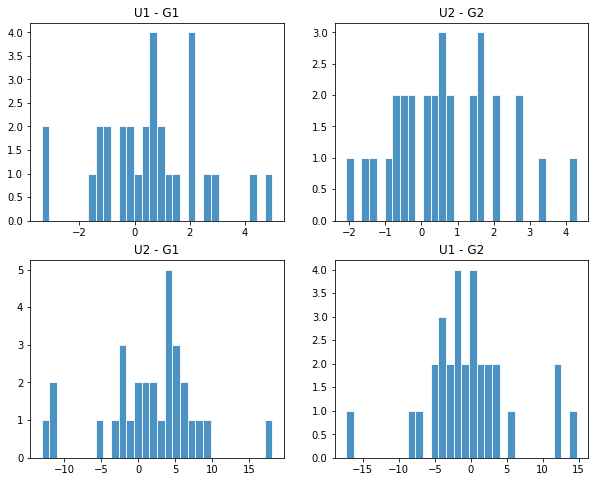

In [132]:
fig,ax = plt.subplots(2,2,figsize=(10,8))
ax[0][0].hist(first_adj_lstm,alpha= 0.8,bins=30,edgecolor='white')
ax[0][0].set_title('U1 - G1')
ax[0][1].hist(second_adj_lstm,alpha= 0.8,bins=30,edgecolor='white')
ax[0][1].set_title('U2 - G2')
ax[1][0].hist(lstm,alpha= 0.8,bins=30,edgecolor='white')
ax[1][0].set_title('U2 - G1')
ax[1][1].hist(second_class_lstm,alpha= 0.8,bins=30,edgecolor='white')
ax[1][1].set_title('U1 - G2')